In [337]:
# installing

!pip install sqlalchemy
!pip install pyodbc

In [338]:
# importing

from sqlalchemy import create_engine, MetaData, Table, inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


In [339]:
# creating an engine and connecting

def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication:
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [340]:
engine = new_engine('mssql', 'MARINA', 'AdventureWorks2022', integrated_security=True)

mssql://MARINA/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server


In [341]:
connection = engine.connect()

### Querying the database

In [342]:
# The most popular products

top_products = """
SELECT TOP 10 Product.Name AS ProductName,
    SUM(SalesOrderDetail.OrderQty) AS TotalQtySold
FROM Production.Product
INNER JOIN Sales.SalesOrderDetail
    ON Product.ProductID = SalesOrderDetail.ProductID
GROUP BY Product.Name
ORDER BY TotalQtySold DESC;
"""

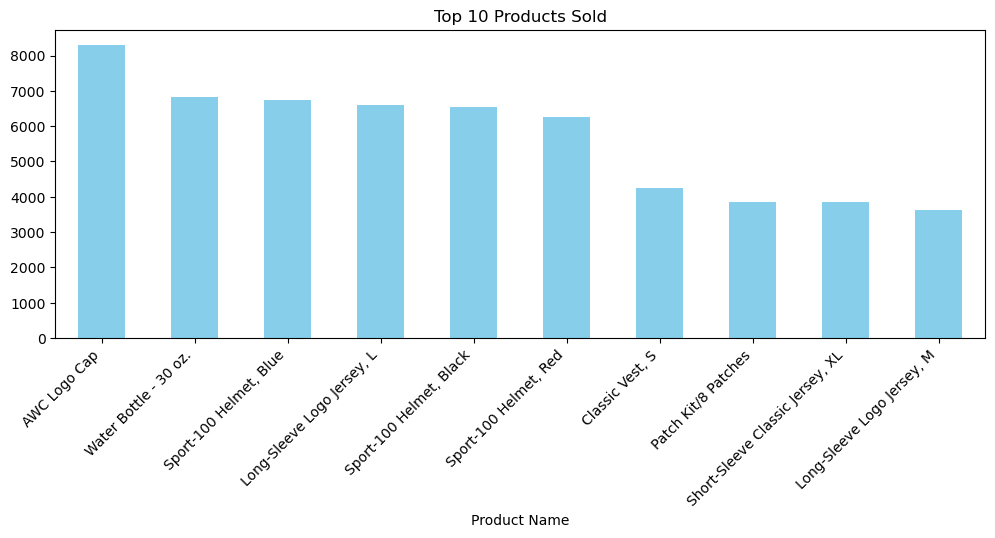

In [343]:
# visualizing the top 10 most sold products

top_products_df = pd.read_sql(sql=top_products, con=connection)
top_products_df.plot(kind='bar', x='ProductName', y='TotalQtySold', figsize=(12, 4), legend=False, color='skyblue')
plt.xlabel('Product Name')
plt.title('Top 10 Products Sold')
plt.xticks(rotation=45, ha='right')
plt.show()

In [344]:
# Sales by territory

sales_terr = """
SELECT SalesTerritory.[Group] AS Territory,
    ROUND(SUM(SalesOrderHeader.TotalDue), 2)/1000000 AS TotalSales
FROM Sales.SalesTerritory
INNER JOIN Sales.SalesOrderHeader
    ON SalesTerritory.TerritoryID = SalesOrderHeader.TerritoryID
GROUP BY SalesTerritory.[Group]
ORDER BY TotalSales DESC;
"""

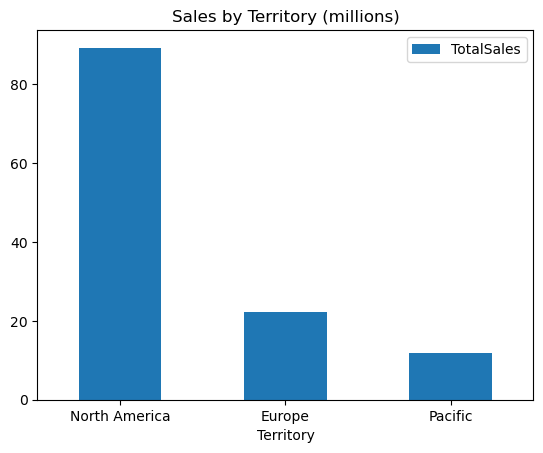

In [345]:
# visualizing

sales_terr_df = pd.read_sql(sql=sales_terr, con=connection)
sales_terr_df.plot(kind='bar', y='TotalSales', x='Territory')
plt.title('Sales by Territory (millions)')
plt.xticks(rotation=0)
plt.show()

In [346]:
# Sales by year

sales_year = """
SELECT YEAR(OrderDate) AS SalesYear, 
    ROUND(SUM(TotalDue), 2) / 1000000 AS Sales 
FROM Sales.SalesOrderHeader 
GROUP BY YEAR(OrderDate)
ORDER BY SalesYear;
"""

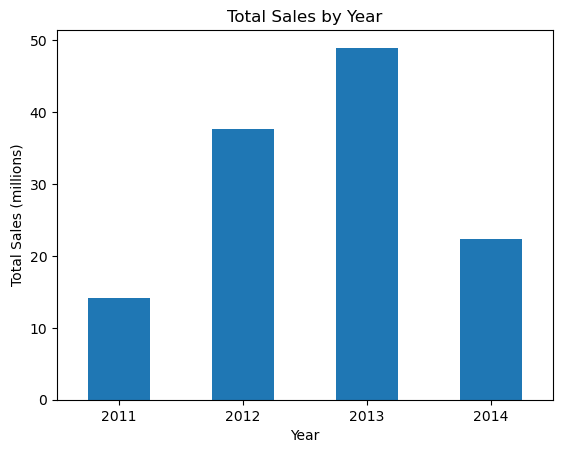

In [347]:
# # visualizing

sales_year_df = pd.read_sql(sql=sales_year, con=connection)
sales_year_df.plot(kind='bar', x='SalesYear', y='Sales', legend=False,)
plt.title('Total Sales by Year')
plt.xlabel('Year')
plt.ylabel('Total Sales (millions)')
plt.xticks(rotation=0)
plt.show()

In [348]:
# Top 10 customers with the highest total purchase amount

top_cust = """
SELECT TOP 10 SC.CustomerID,
    P.FirstName + ' ' + P.LastName AS CustomerName,
    ROUND(SUM(SOH.TotalDue), 2)/1000000 AS TotalPurchaseAmount
FROM Sales.Customer AS SC
INNER JOIN Person.Person AS P
    ON SC.PersonID = P.BusinessEntityID
INNER JOIN Sales.SalesOrderHeader AS SOH 
    ON SC.CustomerID = SOH.CustomerID
GROUP BY SC.CustomerID, P.FirstName, P.LastName
ORDER BY TotalPurchaseAmount DESC;
""" 

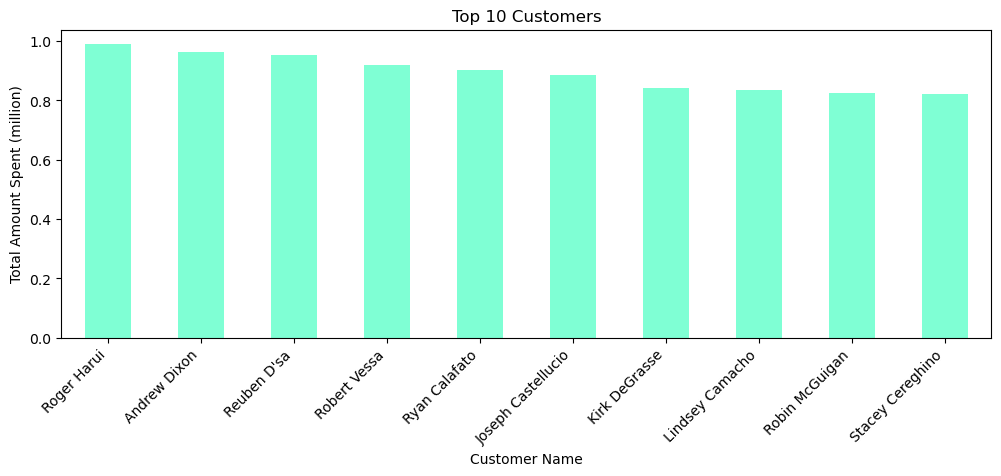

In [349]:
# visualizing the top 10 customers

top_cust_df = pd.read_sql(sql=top_cust, con=connection)
top_cust_df.plot(kind='bar', x='CustomerName', y='TotalPurchaseAmount', figsize=(12, 4), legend=False, color='aquamarine')
plt.xlabel('Customer Name')
plt.ylabel('Total Amount Spent (million)')
plt.title('Top 10 Customers')
plt.xticks(rotation=45, ha='right')
plt.show()

In [350]:
# The average list price by year:

aver_price = """
SELECT YEAR(SOH.OrderDate) AS SalesYear,
    AVG(P.ListPrice) AS AvgListPrice
FROM Sales.SalesOrderHeader AS SOH
INNER JOIN Sales.SalesOrderDetail AS SOD
    ON SOD.SalesOrderID = SOH.SalesOrderID
INNER JOIN Production.Product AS P
    ON SOD.ProductID = P.ProductID
GROUP BY YEAR(SOH.OrderDate)
ORDER BY SalesYear;
"""

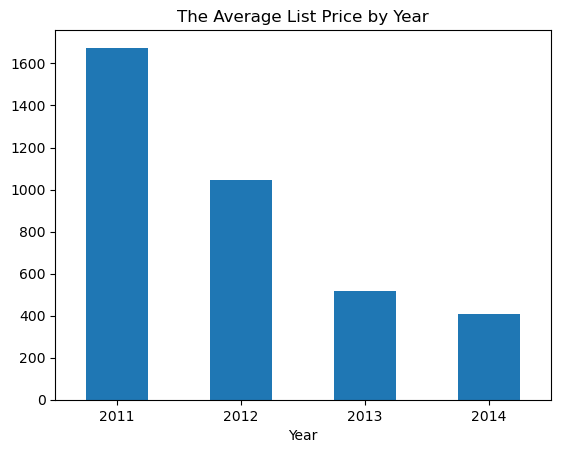

In [351]:
# visualizing

aver_price_df = pd.read_sql(sql=aver_price, con=connection)
aver_price_df.plot(kind='bar', y='AvgListPrice', x='SalesYear', legend=False)
plt.title('The Average List Price by Year')
plt.xticks(rotation=0)
plt.xlabel('Year')
plt.show()

In [352]:
# Getting list prices for calculating 95% CI

list_price = """
SELECT YEAR(SOH.OrderDate) AS SalesYear,
    P.ListPrice
FROM Sales.SalesOrderHeader AS SOH
INNER JOIN Sales.SalesOrderDetail AS SOD
    ON SOD.SalesOrderID = SOH.SalesOrderID
INNER JOIN Production.Product AS P
    ON SOD.ProductID = P.ProductID
WHERE P.ListPrice IS NOT NULL
ORDER BY SalesYear;
"""


In [353]:
list_price_df = pd.read_sql(sql=list_price, con=connection)

# Group by year to calculate the mean and standard error
grouped = list_price_df.groupby('SalesYear')['ListPrice']

# Calculate mean, standard deviation, and count for each year
mean_prices = grouped.mean()
std_dev_prices = grouped.std()
n = grouped.count()

# 95% confidence interval (z-score = 1.96 for 95%)
z = 1.96
stderr = std_dev_prices / np.sqrt(n)  # Standard error
lower_bound = mean_prices - z * stderr
upper_bound = mean_prices + z * stderr

# Combine the results into a DataFrame for easier plotting
ci_df = pd.DataFrame({
    'MeanPrice': mean_prices,
    'LowerCI': lower_bound,
    'UpperCI': upper_bound
})

# Preview the results
print(ci_df)



             MeanPrice      LowerCI      UpperCI
SalesYear                                       
2011       1674.887145  1637.940059  1711.834230
2012       1045.692627  1031.187814  1060.197440
2013        519.399347   512.901885   525.896808
2014        408.090677   400.642547   415.538807


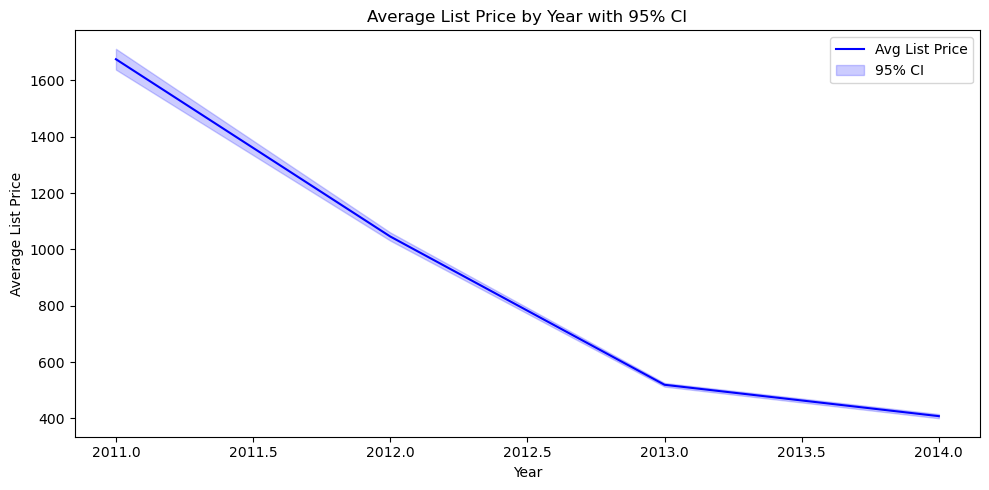

In [354]:
# Visualizing the average price by year with 95% CI

plt.figure(figsize=(10, 5))

plt.plot(ci_df.index, ci_df['MeanPrice'], label='Avg List Price', color='blue')

plt.fill_between(ci_df.index, ci_df['LowerCI'], ci_df['UpperCI'], color='blue', alpha=0.2, label='95% CI')

plt.title('Average List Price by Year with 95% CI')
plt.xlabel('Year')
plt.ylabel('Average List Price')
plt.xticks(rotation=0)
plt.legend()

plt.tight_layout()
plt.show()


In [355]:
# Departments with the most employees

top_dep = """
SELECT TOP 10 D.Name AS DepartmentName,
	COUNT(HRE.BusinessEntityID) AS NumberOfEmployees
FROM HumanResources.Employee AS HRE
INNER JOIN HumanResources.EmployeeDepartmentHistory AS EDH
    ON HRE.BusinessEntityID = EDH.BusinessEntityID
INNER JOIN HumanResources.Department AS D
    ON EDH.DepartmentID = D.DepartmentID
GROUP BY D.Name
ORDER BY NumberOfEmployees DESC;
"""

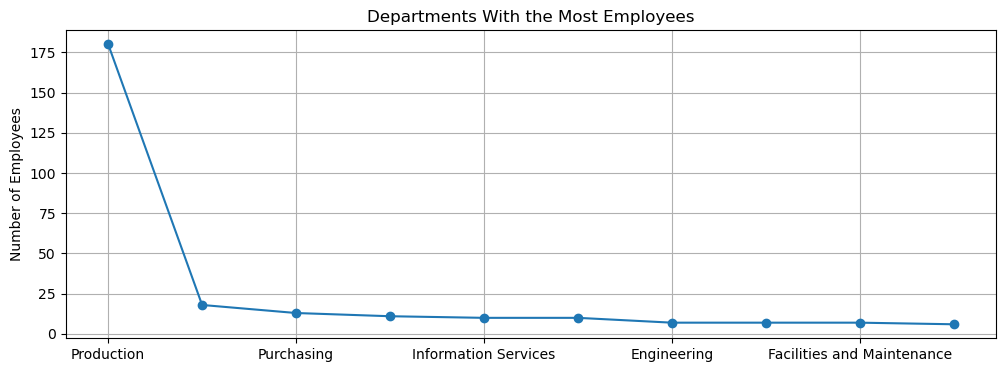

In [356]:
# Visualizing

top_dep_df = pd.read_sql(sql=top_dep, con=connection)
top_dep_df.plot(kind='line', x='DepartmentName', y='NumberOfEmployees', figsize=(12, 4), legend=False, marker='o')
plt.ylabel('Number of Employees')
plt.xlabel('')
plt.title('Departments With the Most Employees')
plt.xticks(rotation=0)
plt.grid()
plt.show()

In [357]:
# Top 3 employees with the highest number of sales

sales_peop = """
SELECT TOP 5 HRE.BusinessEntityID,
	P.FirstName + ' ' + P.LastName AS EmployeeName,
	COUNT(SOH.SalesOrderID) AS TotalSales
FROM HumanResources.Employee AS HRE
INNER JOIN Person.Person AS P
    ON HRE.BusinessEntityID = P.BusinessEntityID
INNER JOIN Sales.SalesOrderHeader AS SOH
    ON HRE.BusinessEntityID = SOH.SalesPersonID
GROUP BY HRE.BusinessEntityID, P.FirstName, P.LastName
ORDER BY TotalSales DESC;
"""

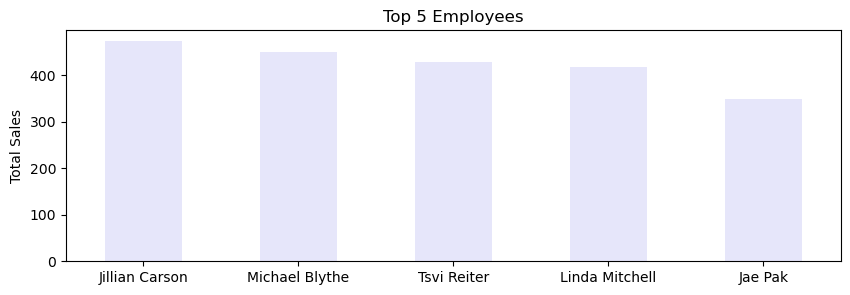

In [358]:
# Visualizing

sales_peop_df = pd.read_sql(sql=sales_peop, con=connection)
sales_peop_df.plot(kind='bar', x='EmployeeName', y='TotalSales', figsize=(10, 3), legend=False, color='lavender')
plt.xlabel('')
plt.ylabel('Total Sales')
plt.title('Top 5 Employees')
plt.xticks(rotation=0)
plt.show()

In [359]:
# Number of products in each product category

numb_prod = """
SELECT PC.Name AS ProductCategory,
	COUNT(P.ProductID) AS TotalProducts
FROM Production.Product AS P
INNER JOIN Production.ProductSubcategory AS PS
    ON P.ProductSubcategoryID = PS.ProductSubcategoryID
INNER JOIN Production.ProductCategory AS PC
    ON PS.ProductCategoryID = PC.ProductCategoryID
GROUP BY PC.Name; 
"""

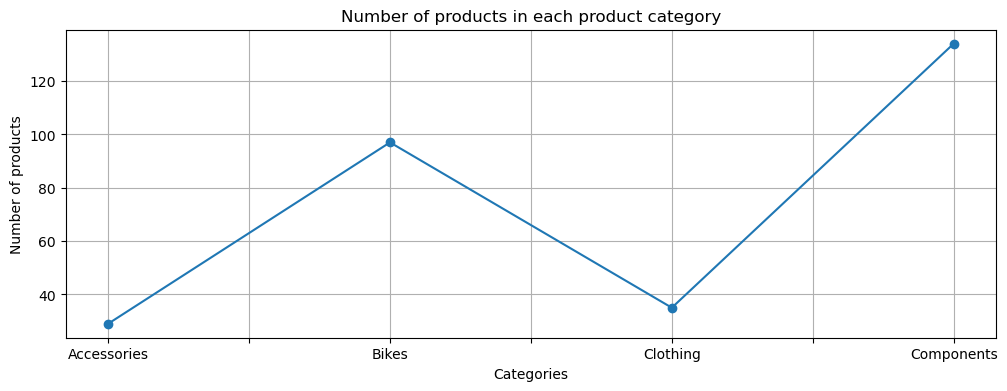

In [360]:
# Visualizing

numb_prod_df = pd.read_sql(sql=numb_prod, con=connection)
numb_prod_df.plot(kind='line', x='ProductCategory', y='TotalProducts', figsize=(12, 4), legend=False, marker='o')
plt.ylabel('Number of products')
plt.xlabel('Categories')
plt.title('Number of products in each product category')
plt.xticks(rotation=0)
plt.grid()
plt.show()